In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline
plt.style.use('ggplot')

# from plots at the end -- TODO: try doing this only with PyTorch.
from scipy.stats import norm

## Normal-normal model
We start with a normal model,
\begin{eqnarray*}
  p(\theta) & \propto & 1, \\
  p(z_i) & = & \text{normal}(0, 1), \\
  \Omega_\mu (z_i, \theta) & = & \theta + \tau z_i, \\
  p(x_i \mid z_i, \theta) & = & \text{normal}(\Omega_\mu(z_i, \theta), \sigma^2),
\end{eqnarray*}
with latent variables $(\theta, z_{1:n})$. This model admits a (non-trivial) analytical expression for the posterior distribution, which is a multivariate Gaussian.

In [3]:
# Generate observations from a hierarchical normal-normal model.
n = 10000
tau = 1.155
sigma = 2.43
x = np.random.normal(size = (n, 1), scale = np.sqrt(tau**2 + sigma**2))

To make fair comparisons between different VI, we pick starting values for the variational parameters, such that all methods start with the same initial ELBO.

In [109]:
# def vi_init(seed):
#     # NOTE: it seems torch "updates" these values once they're passed to a model.
#     torch.manual_seed(seed)
#     nu_mean_theta = torch.randn(1, 1)
#     nu_sd_theta_log = torch.randn(1, 1)
#     alpha0 = torch.randn(1, 1)
#     alpha = torch.randn(1, 1)  # torch.zeros((1, 1))
#     nu_mean_z = alpha0 + alpha * x
#     nu_sd_z_log = torch.randn(1, 1)
    
#     return nu_mean_theta, nu_sd_theta_log, alpha0, alpha, nu_mean_z, nu_sd_z_log

def vi_init(seed):
    # NOTE: it seems torch "updates" these values once they're passed to a model.
    torch.manual_seed(seed)
    nu_mean_theta = torch.randn(1)
    nu_sd_theta_log = torch.randn(1)
    alpha0 = torch.randn(1)
    alpha = torch.randn(1)
    nu_mean_z = (alpha0 + alpha * x).reshape(n)
    nu_sd_z_log = torch.randn(n) # torch.randn(1)
    
    return nu_mean_theta, nu_sd_theta_log, alpha0, alpha, nu_mean_z, nu_sd_z_log


Define distributions to estimate the ELBO.

In [110]:
# Not vectorized, simpler version (i.e. assume only one Monte Carlo estimator)
def log_joint(x, theta, z):
    return -0.5 * torch.sum(z**2) - 1 / (2 * sigma**2)\
              * torch.sum((x - theta - tau * z)**2)

def log_q(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2) * (z - nu_mean_z)**2)
    return log_q_theta + log_q_z

In [111]:
# vectorized version for GPU
def log_joint_v(x, theta, z):
    return -0.5 * torch.sum(z**2, dim = 1) - 1 / (2 * sigma**2)\
              * torch.sum((x - theta[:, None] - tau * z)**2, dim = 1)

def log_q_v(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2) * (z - nu_mean_z)**2,
                        dim = 1)
    return log_q_theta + log_q_z

### Factorized VI

In [118]:
# Tuning parameters for FVI
mc_samples = 20  # for Monte Carlo estimator of ELBO

In [119]:
class MCElbo_FVI(torch.nn.Module):
    def __init__(self):
        super(MCElbo_FVI, self).__init__()
        
        nu_mean_theta_init, nu_sd_theta_log_init, _alpha0, _alpha, nu_mean_z_init,\
          nu_sd_z_log_init = vi_init(1954)

        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.nu_mean_z = torch.nn.Parameter(nu_mean_z_init, requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init, requires_grad = True)

        self.mc_samples = mc_samples

    def generate_rand(self, m):
        eps_theta = np.random.normal(size = m)
        eps_z = np.random.normal(size = (m, n))
        return eps_theta, eps_z
        
#     def generate_rand(self):
#         eps_theta = np.random.normal(size = (1, 1))
#         eps_z = np.random.normal(size = (n, 1))
#        return eps_theta, eps_z

    def reparam(self, eps_theta, eps_z):
        eps_theta = Variable(torch.FloatTensor(eps_theta))
        eps_z = Variable(torch.FloatTensor(eps_z))
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(self.nu_mean_z)

    def compute_elbo(self, x):
        eps_theta, eps_z = self.generate_rand(self.mc_samples)
        theta, z = self.reparam(eps_theta, eps_z)
        Elbo = log_joint_v(x, theta, z)\
          - log_q_v(theta, z, 
                    self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                    self.nu_mean_z, torch.exp(self.nu_sd_z_log))
        return torch.mean(Elbo)

#     def compute_elbo_sample(self, x):
#         eps_theta, eps_z = self.generate_rand()
#         theta, z = self.reparam(eps_theta, eps_z)
#         # x_torch = torch.tensor(x)[:,0].repeat(self.mc_samples, 1)
#         # Compute Elbo integrand using mc_samples draws
#         Elbo = log_joint(x, theta, z)\
#                    - log_q(theta, z,
#                            self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
#                            self.nu_mean_z, torch.exp(self.nu_sd_z_log))
#         return Elbo   # torch.mean(Elbo)
    
#     def compute_elbo(self, x):
#         Elbo_mean = self.compute_elbo_sample(x)
#         for i in range(1, self.mc_samples):
#             Elbo_mean = i * Elbo_mean / (i + 1) + self.compute_elbo_sample(x) / (i + 1)

#        return Elbo_mean  


In [120]:
%%time
model = MCElbo_FVI()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
x_torch = Variable(torch.tensor(x), requires_grad = False).reshape(n)

n_iter_optimizer = int(5e3)
loss_saved = np.empty((n_iter_optimizer,))

for i in range(n_iter_optimizer):
    loss = - model.compute_elbo(x_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_saved[i] = loss.data.numpy()
    if i % 1000  == 0:
        # for now, only keep track of the variational parameters of theta
        print("loss", loss.data.numpy())
        print(model.nu_mean_theta.data.numpy(), torch.exp(model.nu_sd_theta_log).data.numpy())


loss 86910.6856973584
[0.32128695] [2.0042746]
loss 6224.845017424499
[-0.03612445] [0.2259368]
loss 5969.975324614277
[0.0042999] [0.12476981]
loss 5955.544521527038
[-0.00317161] [0.0843495]
loss 5950.766676462509
[-0.00447813] [0.06180522]
CPU times: user 2min 36s, sys: 7.73 s, total: 2min 44s
Wall time: 41.7 s


In [115]:
# Get final result from training model
print("loss", loss.data.numpy())
mf_mean_theta = model.nu_mean_theta.data.numpy()
mf_sd_theta = torch.exp(model.nu_sd_theta_log).data.numpy()
print(mf_mean_theta, mf_sd_theta)

# Expected results for marginal posterior of theta
print(np.mean(x))  # mean
print(np.sqrt((tau**2 + sigma**2) / n))  # sd

loss 5957.656471486802
[-0.0009488] [0.04857584]
-0.005887142065433192
0.02690525041697252


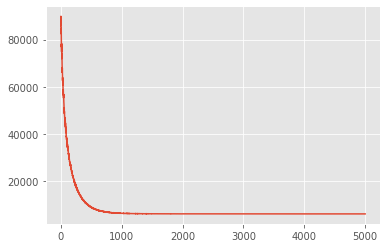

In [116]:
plt.plot(loss_saved)

###  Amortized VI
We consider AVI using a polynomial inference function of degree up to 2.
In the amortized family,
\begin{equation*}
  q(z_i; x_i) = \text{normal}(f_\mu(x_i, \eta), f_{\sigma^2}(x_i, \eta)),
\end{equation*}
where
\begin{eqnarray*}
  f_\mu(x_i, \eta) & = & \alpha_0 + \alpha x_i + \beta x_i^2 \\
  f_{\sigma^2}(x_i, \eta) & = & \eta_{\sigma^2},
\end{eqnarray*}
meaning we need to optimize over three variational parameters, $\eta = (\alpha_0, \alpha, \beta, \eta_{\sigma^2})$, regardless of what $n$ may be.

In [127]:
class MCElbo_AVI(torch.nn.Module):
    def __init__(self):
        super(MCElbo_AVI, self).__init__()
        nu_mean_theta_init, nu_sd_theta_log_init, alpha0_init, alpha_init,\
          __mean_z, nu_sd_z_log_init = vi_init(1954)
        
        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.alpha0 = torch.nn.Parameter(alpha0_init, requires_grad = True)
        self.alpha = torch.nn.Parameter(alpha_init, requires_grad = True)
        self.beta = torch.nn.Parameter(torch.zeros((1, 1)), requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init, requires_grad = True)
        
        self.mc_samples = mc_samples
        
#     def generate_rand(self):
#         eps_theta = np.random.normal(size = (1, 1))
#         eps_z = np.random.normal(size = (n, 1))
#         return eps_theta, eps_z
    
    def generate_rand(self, m):
        eps_theta = np.random.normal(size = m)
        eps_z = np.random.normal(size = (m, n))
        return eps_theta, eps_z

    def reparam(self, eps_theta, eps_z, x, nu_mean_z):
        eps_theta = Variable(torch.FloatTensor(eps_theta))
        eps_z = Variable(torch.FloatTensor(eps_z))
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(nu_mean_z)

    def compute_elbo_sample(self, x, nu_mean_z):
        eps_theta, eps_z = self.generate_rand()
        theta, z = self.reparam(eps_theta, eps_z, x, nu_mean_z)

        elbo = log_joint(x, theta, z) - log_q(theta, z, self.nu_mean_theta,
                                              torch.exp(self.nu_sd_theta_log),
                                              nu_mean_z,
                                              torch.exp(self.nu_sd_z_log))
        return elbo        
    
    def compute_elbo(self, x, poly_degree):
        if (poly_degree == 0):
            nu_mean_z = self.alpha0
        if (poly_degree == 1):
            nu_mean_z = self.alpha0 + self.alpha.mul(x)
        if (poly_degree == 2):
            nu_mean_z = self.alpha0 + self.alpha.mul(x) + self.beta.mul(x**2)
        
        eps_theta, eps_z = self.generate_rand(self.mc_samples)
        theta, z = self.reparam(eps_theta, eps_z, x, nu_mean_z)
        
        Elbo = log_joint_v(x, theta, z)\
          - log_q_v(theta, z, 
                    self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                    nu_mean_z, torch.exp(self.nu_sd_z_log))
        return torch.mean(Elbo)        

        # Elbo_mean = self.compute_elbo_sample(x, nu_mean_z)
        # for i in range(1, self.mc_samples):
        #    Elbo_mean = i * Elbo_mean / (i + 1) + self.compute_elbo_sample(x, nu_mean_z) / (i + 1)
        return Elbo_mean


In [128]:
%%time
model_avi_0 = MCElbo_AVI()
optimizer = torch.optim.Adam(model_avi_0.parameters(), lr = 1e-2)
poly_degree = 0

n_iter_optimizer = int(5e3)
loss_avi_0_saved = np.empty(n_iter_optimizer)
for i in range(n_iter_optimizer):
    loss = - model_avi_0.compute_elbo(x_torch, poly_degree)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_avi_0_saved[i] = loss
    if i % 1000  == 0:
        # for now, only keep track of the variational parameters of theta
        print("loss", loss.data.numpy())
        print(model_avi_0.nu_mean_theta.data.numpy(),
              torch.exp(model_avi_0.nu_sd_theta_log).data.numpy())


loss 51508.891044274314
[0.30128697] [2.0042746]
loss 7212.960882623922
[-0.01117739] [0.22025372]
loss 7080.437167994789
[-0.00100023] [0.12316743]
loss 7060.626174165844
[0.00365084] [0.08343134]
loss 7052.540025080964
[-0.00593794] [0.06081631]
CPU times: user 2min 19s, sys: 2.38 s, total: 2min 21s
Wall time: 35.8 s


In [129]:
%%time
model_avi_1 = MCElbo_AVI()
optimizer = torch.optim.Adam(model_avi_1.parameters(), lr = 1e-2)
poly_degree = 1

n_iter_optimizer = int(5e3)
loss_avi_1_saved = np.empty(n_iter_optimizer)
for i in range(n_iter_optimizer):
    loss = - model_avi_1.compute_elbo(x_torch, poly_degree)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_avi_1_saved[i] = loss
    if i % 1000  == 0:
        # for now, only keep track of the variational parameters of theta
        print("loss", loss.data.numpy())
        print(model_avi_1.nu_mean_theta.data.numpy(),
              torch.exp(model_avi_1.nu_sd_theta_log).data.numpy())


loss 86778.75828878584
[0.30128697] [2.0042746]
loss 6101.471958191937
[-0.00460271] [0.22012225]
loss 5958.39757639852
[-0.00913773] [0.12137212]
loss 5948.099875036214
[-9.0253714e-05] [0.08199174]
loss 5948.6077906932915
[-0.00144704] [0.06042863]
CPU times: user 2min 38s, sys: 7.49 s, total: 2min 45s
Wall time: 42 s


In [130]:
%%time
model_avi_2 = MCElbo_AVI()
optimizer = torch.optim.Adam(model_avi_2.parameters(), lr = 1e-2)
poly_degree = 2

n_iter_optimizer = int(5e3)
loss_avi_2_saved = np.empty(n_iter_optimizer)
for i in range(n_iter_optimizer):
    loss = - model_avi_2.compute_elbo(x_torch, poly_degree)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_avi_2_saved[i] = loss
    if i % 1000  == 0:
        # for now, only keep track of the variational parameters of theta
        print("loss", loss.data.numpy())
        print(model_avi_2.nu_mean_theta.data.numpy(),
              torch.exp(model_avi_2.nu_sd_theta_log).data.numpy())


loss 89919.30209777778
[0.30128697] [2.0042746]
loss 6063.198813365825
[-0.00537864] [0.21562055]
loss 5970.222084603781
[-0.00438645] [0.12054174]
loss 5949.167536185113
[-0.00423135] [0.081579]
loss 5945.798335711722
[-0.0104656] [0.05984379]
CPU times: user 2min 41s, sys: 7.63 s, total: 2min 48s
Wall time: 42.8 s


In [131]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.matplotlib.rc('font', **font)
# mpl.rcParams.update({"axes.grid" : True, "grid.color": "black"})


<ipython-input-132-ddc011c05963>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


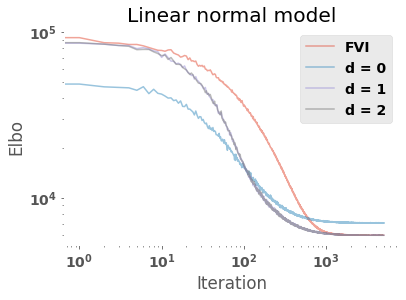

In [132]:
# plt.plot(loss_saved, label = 'mean field')
plt.plot(loss_saved, label = 'FVI', alpha = 0.5)
plt.plot(loss_avi_0_saved, label = 'd = 0', alpha = 0.5)
plt.plot(loss_avi_1_saved, label = 'd = 1', alpha = 0.5)
plt.plot(loss_avi_2_saved, label = 'd = 2', alpha = 0.5)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc = "best")
plt.title("Linear normal model")
plt.xlabel("Iteration")
plt.ylabel("Elbo")

ax = plt.axes()
ax.set_facecolor("white")
# ax.grid(which = 'major', b = 'true', c = 'grey')
plt.savefig("to_discuss/elbo_lin_normal.pdf")
plt.show()


In [133]:
def mean_window(loss, index_center, window):
    return np.mean(loss[(index_center - window):(index_center + window)])

def sd_window(loss, index_center, window):
    return np.std(loss[(index_center - window):(index_center + window)]) 

In [134]:
# Get asymptotic ELBO
index_center = 4500
window = 500
print("FVI: ", mean_window(loss_saved, 4500, window), " +/- ",
     sd_window(loss_saved, 4500, window))
print("d = 0: ", mean_window(loss_avi_0_saved, 4500, window), " +/- ",
     sd_window(loss_avi_0_saved, 4500, window))
print("d = 1: ", mean_window(loss_avi_1_saved, 4500, window), " +/- ",
     sd_window(loss_avi_1_saved, 4500, window))
print("d = 2: ", mean_window(loss_avi_2_saved, 4500, window), " +/- ",
     sd_window(loss_avi_2_saved, 4500, window))

FVI:  5950.9888102589985  +/-  1.3718807916191655
d = 0:  7055.986605029382  +/-  10.70663095501847
d = 1:  5945.424232576095  +/-  1.1848424765769636
d = 2:  5945.685730939474  +/-  1.2657220767983224


In [135]:
# Estimate number of iterations to convergence.
def iter_convergence(loss, target, tol, init_iteration = 1000, window = 500, grid = 100,
                    max_iteration = 5000):
    iteration = init_iteration
    diff = abs(mean_window(loss, iteration, window) - target)
    while(diff > tol and iteration <= max_iteration):
        iteration += grid
        diff = abs(mean_window(loss, iteration, window) - target)
    return iteration

# Q: should we report convergence to F-VI's solution or for each individual
# solution?
def iter_conv_wrapper(loss):
    return iter_convergence(loss, target = mean_window(loss_saved, 4500, window),
                            tol = sd_window(loss_saved, 4500, window))


In [136]:
print("FVI:", iter_conv_wrapper(loss_saved))
print("d = 0:", iter_conv_wrapper(loss_avi_0_saved))
print("d = 1:", iter_conv_wrapper(loss_avi_1_saved))
print("d = 2:", iter_conv_wrapper(loss_avi_2_saved))


FVI: 3800
d = 0: 5100
d = 1: 2900
d = 2: 2900


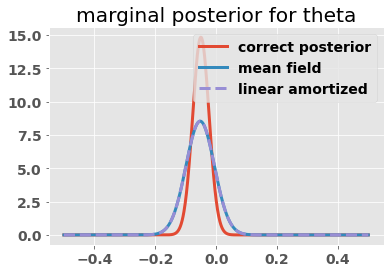

In [26]:
xn = np.arange(-0.5, 0.5, 0.001)
true_dist = norm(loc = np.mean(x),
                scale = np.sqrt((tau**2 + sigma**2) / n))

q_mf_dist = norm(loc = mf_mean_theta,
                 scale = mf_sd_theta)

q_am_dist = norm(loc = model.nu_mean_theta.data.numpy(),
                 scale = torch.exp(model.nu_sd_theta_log).data.numpy())

plt.plot(xn, true_dist.pdf(xn).ravel(), linewidth = 3, label = "correct posterior")
plt.plot(xn, q_mf_dist.pdf(xn).ravel(), linewidth = 3, label = "mean field")
plt.plot(xn, q_am_dist.pdf(xn).ravel(), '--', linewidth = 3, label = "linear amortized")
plt.title("marginal posterior for theta")
plt.legend()
plt.savefig("to_discuss/marginal_theta.pdf")
plt.show()

## ToDo: examine other marginal, and maybe some joints...

# Normal-Normal with unknown prior variance
Same model as before, but this time the prior variance is unknown. This slight complication of the model means we no longer have access to analytical solutions.
\begin{eqnarray*}
  p(\theta) & \propto & 1, \\
  p(\tau) & = & \text{log-norma}(0, 1), \\
  p(z_i) & = & \text{normal}(0, 1), \\
  \Omega_\mu (z_i, \theta) & = & \theta + \tau z_i, \\
  p(x_i \mid z_i, \theta) & = & \text{normal}(\Omega_\mu(z_i, \theta), \sigma^2),
\end{eqnarray*}

Notes: 
* Can re-use the data simulated in the previous section.
* Since we operate on the unconstrained scale, the model is parameterized in terms of $p(\log \tau) = \text{normal}(0, 1)$.

### Mean field VI

In [ ]:
# Common initializations
torch.manual_seed(1954)
nu_mean_theta_init = torch.randn(1, 1)
nu_sd_theta_log_init = torch.randn(1, 1)
nu_mean_log_tau_init = torch.randn(1, 1)
nu_sd_log_tau_log_init = torch.randn(1, 1)
alpha0_init = torch.randn(1, 1)
alpha_init = torch.randn(1, 1)
nu_mean_z_init = alpha0_init + alpha_init * x

nu_sd_z_log_init = torch.randn(1, 1)

In [ ]:
def log_joint(x, theta, log_tau, z):
    return -0.5 * torch.sum(z**2) - 1 / (2 * sigma**2)\
               * torch.sum((x - theta - z)**2)\
               - 0.5 * log_tau**2

def log_q(theta, log_tau, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z,
          nu_mean_log_tau, nu_sd_log_tau):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    
    log_q_tau = - torch.log(nu_sd_log_tau) - 1 / (2 * nu_sd_log_tau**2)\
                                                       * (log_tau - nu_mean_log_tau)**2

    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2) * (z - nu_mean_z)**2)

    return log_q_theta + log_q_tau + log_q_z

In [ ]:
class MCElbo_meanfield_nnt(torch.nn.Module):
    def __init__(self):
        super(MCElbo_meanfield_nnt, self).__init__()
        
        # Use common initialization
        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.nu_mean_log_tau = torch.nn.Parameter(nu_mean_log_tau_init, requires_grad = True)
        self.nu_sd_log_tau_log = torch.nn.Parameter(nu_sd_log_tau_log_init,
                                                    requires_grad = True)
        self.nu_mean_z = torch.nn.Parameter(nu_mean_z_init, requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init, requires_grad = True)

        self.mc_samples = 50

    def generate_rand(self):
        eps_theta = np.random.normal(size = (1, 1))
        eps_tau_log = np.random.normal(size = (1, 1))
        eps_z = np.random.normal(size = (n, 1))

        return eps_theta, eps_tau_log, eps_z
        
    def reparam(self, eps_theta, eps_log_tau, eps_z):
        eps_theta = Variable(torch.FloatTensor(eps_theta))
        eps_log_tau = Variable(torch.FloatTensor(eps_log_tau))
        eps_z = Variable(torch.FloatTensor(eps_z))
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_log_tau.mul(torch.exp(self.nu_sd_log_tau_log)).add(self.nu_mean_log_tau),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(self.nu_mean_z)
    
    def compute_elbo_sample(self, x):
        eps_theta, eps_log_tau, eps_z = self.generate_rand()
        theta, log_tau, z = self.reparam(eps_theta, eps_log_tau, eps_z)
        Elbo = log_joint(x, theta, log_tau, z)\
               - log_q(theta, log_tau, z,
                         self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                         self.nu_mean_z, torch.exp(self.nu_sd_z_log),
                         self.nu_mean_log_tau, torch.exp(self.nu_sd_log_tau_log))
        return Elbo

    def compute_elbo(self, x):
        Elbo_mean = self.compute_elbo_sample(x)
        for i in range(1, self.mc_samples):
            Elbo_mean = i * Elbo_mean / (i + 1) + self.compute_elbo_sample(x) / (i + 1)
        
        return Elbo_mean
    

In [ ]:
model = MCElbo_meanfield_nnt()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
x_torch = Variable(torch.tensor(x), requires_grad = False)

n_iter_optimizer = int(5e3)
loss_saved = np.empty((n_iter_optimizer,))

for i in range(n_iter_optimizer):
    loss = - model.compute_elbo(x_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_saved[i] = loss.data.numpy()
    if i % 1000  == 0:
        # for now, only keep track of the variational parameters of theta
        print("loss", loss.data.numpy())
        print(model.nu_mean_theta.data.numpy(), torch.exp(model.nu_sd_theta_log).data.numpy())
        print(model.nu_mean_log_tau.data.numpy(), model.nu_sd_log_tau_log.data.numpy())


In [ ]:
# Get final result from training model
print("loss", loss.data.numpy())
mf_mean_theta = model.nu_mean_theta.data.numpy()
mf_sd_theta = torch.exp(model.nu_sd_theta_log).data.numpy()
print(mf_mean_theta, mf_sd_theta)

# Expected results for marginal posterior of theta
print(np.mean(x))  # mean
print(np.sqrt((tau**2 + sigma**2) / n))  # sd

In [ ]:
plt.plot(loss_saved)
plt.yscale("log")
plt.xscale("log")

### Linear Amortized VI

In [ ]:
# Common initializations
torch.manual_seed(1954)
nu_mean_theta_init = torch.randn(1, 1)
nu_sd_theta_log_init = torch.randn(1, 1)
nu_mean_log_tau_init = torch.randn(1, 1)
nu_sd_log_tau_log_init = torch.randn(1, 1)
alpha0_init = torch.randn(1, 1)
alpha_init = torch.randn(1, 1)
nu_mean_z_init = alpha0_init + alpha_init * x

nu_sd_z_log_init = torch.randn(1, 1)

In [ ]:
def log_amortized_q(theta, log_tau, z, nu_mean_theta, nu_sd_theta, nu_mean_log_tau,
                    nu_sd_log_tau, alpha0, alpha, nu_sd, x):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    
    # log_q_tau = 0
    log_q_tau = - torch.log(nu_sd_log_tau) - 1 / (2 * nu_sd_log_tau**2)\
                                                       * (log_tau - nu_mean_log_tau)**2
    
    log_q_z = torch.sum(- torch.log(nu_sd) - 1 / (2 * nu_sd**2) * (z - alpha0 - alpha * x)**2)
    
    return log_q_theta + log_q_tau + log_q_z


In [ ]:
class MCElbo_linear_arm_nnt(torch.nn.Module):
    def __init__(self):
        super(MCElbo_linear_arm_nnt, self).__init__()

        # Use common initialization
        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.nu_mean_log_tau = torch.nn.Parameter(nu_mean_log_tau_init, requires_grad = True)
        self.nu_sd_log_tau_log = torch.nn.Parameter(nu_sd_log_tau_log_init,
                                                    requires_grad = True)
        self.alpha0 = torch.nn.Parameter(alpha0_init, requires_grad = True)
        self.alpha = torch.nn.Parameter(alpha_init, requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init, requires_grad = True)
        
        self.mc_samples = 50

    def generate_rand(self):
        eps_theta = np.random.normal(size = (1, 1))
        eps_tau_log = np.random.normal(size = (1, 1))
        eps_z = np.random.normal(size = (n, 1))
        return eps_theta, eps_tau_log, eps_z

    def reparam(self, eps_theta, eps_tau_log, eps_z, x):
        eps_theta = Variable(torch.FloatTensor(eps_theta))
        eps_log_tau = Variable(torch.FloatTensor(eps_tau_log))
        eps_z = Variable(torch.FloatTensor(eps_z))

        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_log_tau.mul(torch.exp(self.nu_sd_log_tau_log)).add(self.nu_mean_log_tau),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(self.alpha0).add(self.alpha.mul(x))        

    def compute_elbo_sample(self, x):
        eps_theta, eps_log_tau, eps_z = self.generate_rand()
        theta, log_tau, z = self.reparam(eps_theta, eps_log_tau, eps_z, x)
        
        elbo = log_joint(x, theta, log_tau, z)\
          - log_amortized_q(theta, log_tau, z,
                            self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                            self.nu_mean_log_tau, torch.exp(self.nu_sd_log_tau_log),
                            self.alpha0, self.alpha, torch.exp(self.nu_sd_z_log), x)        
        return elbo

    def compute_elbo(self, x):
        Elbo_mean = self.compute_elbo_sample(x)
        for i in range(1, self.mc_samples):
            Elbo_mean = i * Elbo_mean / (i + 1) + self.compute_elbo_sample(x) / (i + 1)
        return Elbo_mean


In [ ]:
model_arm = MCElbo_linear_arm_nnt()

optimizer = torch.optim.Adam(model_arm.parameters(), lr = 1e-2)
x_torch = Variable(torch.tensor(x), requires_grad = False)

n_iter_optimizer = int(5e3)  # 5e3
loss_am_saved = np.empty(n_iter_optimizer)
for i in range(n_iter_optimizer):
    loss = - model_arm.compute_elbo(x_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_am_saved[i] = loss
    if i % 1000  == 0:
        print("loss", loss.data.numpy())
        print(model_arm.nu_mean_theta.data.numpy(),
              torch.exp(model_arm.nu_sd_theta_log).data.numpy())
        

In [ ]:
# "Final" result
print("loss", loss.data.numpy())
print(model_arm.nu_mean_theta.data.numpy(), torch.exp(model_arm.nu_sd_theta_log).data.numpy())

# Expected results for marginal posterior of theta
print(np.mean(x))
print(np.sqrt((tau**2 + sigma**2) / n))

In [ ]:
plt.plot(loss_am_saved, label = 'linear amortized', alpha = 0.5)
plt.plot(loss_saved, label = 'mean field', alpha = 0.5)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc = "best")
plt.title("Elbo, n = " + str(n))
plt.savefig("to_discuss/elbo.pdf")
plt.show()

In [ ]:
mf_means = [model.nu_mean_theta.data.numpy(),
            model.nu_mean_log_tau.data.numpy(),
            model.nu_mean_z.data.numpy()[0]]

mf_sd = [torch.exp(model.nu_sd_theta_log).data.numpy(),
         torch.exp(model.nu_sd_log_tau_log).data.numpy(),
         torch.exp(model.nu_sd_z_log[0]).data.numpy()]

arm_means = [model_arm.nu_mean_theta.data.numpy(),
             model_arm.nu_mean_log_tau.data.numpy(),
             model_arm.alpha0.data.numpy() + model_arm.alpha.data.numpy() * x[0]]

arm_sd = [torch.exp(model_arm.nu_sd_theta_log).data.numpy(),
          torch.exp(model_arm.nu_sd_log_tau_log).data.numpy(),
          torch.exp(model_arm.nu_sd_z_log).data.numpy()]


In [ ]:
# TODO: get a benchmark (e.g. with long MCMC runs...)
xn = np.arange(-2.5, 2.5, 0.001)
# true_dist = norm(loc = np.mean(x),
#                 scale = np.sqrt((tau**2 + sigma**2) / n))

index = 2

q_mf_dist = norm(loc = mf_means[index], scale = mf_sd[index])
q_am_dist = norm(loc = arm_means[index], scale = arm_sd[index])


# plt.plot(xn, true_dist.pdf(xn).ravel(), linewidth = 3, label = "correct posterior")
plt.plot(xn, q_mf_dist.pdf(xn).ravel(), linewidth = 3, label = "mean field")
plt.plot(xn, q_am_dist.pdf(xn).ravel(), '--', linewidth = 3, label = "linear amortized")
plt.title("marginal posterior for theta")
plt.legend()
plt.savefig("to_discuss/marginal_theta.pdf")
plt.show()

# Draft Code

In [ ]:
# Test code...
theta = torch.normal(mean = torch.mean(x_torch).repeat(10, 1), std = 1)
z = torch.normal(mean = torch.tensor([0.]).repeat(10, 1), std = 2.3)

nu_mean_theta = torch.tensor([np.mean(x)])
nu_sd_theta = torch.tensor([2.1])
alpha0 = torch.tensor([np.mean(x)])
alpha = torch.tensor([0.2])
nu_sd = torch.tensor([0.8])

x_torch = torch.tensor(x)[:,0].repeat(10, 1)

log_am_q = log_amortized_q(theta, z, nu_mean_theta, nu_sd_theta, alpha0, alpha, nu_sd, x_torch)
print(log_am_q.size())

In [ ]:
alpha0 = torch.randn(1,)
alpha = torch.randn(1,)
test_mean = (alpha0 + alpha * x_torch).repeat(100, 1, 1).reshape(100, 5)
print(alpha0.size())
print((alpha * x_torch).size())
print(test_mean.size())

In [ ]:
# draft code
test_mean = torch.tensor([0., 10, 1, 0., -1.])
test_sd = torch.tensor([1])
print(torch.normal(mean = test_mean, std = test_sd))

test_mean_theta = torch.tensor([0.])
test_sd_theta = torch.tensor([1.])
print(torch.normal(mean = test_mean_theta, std = test_sd_theta))

test_mean_repeat = test_mean.repeat(10, 1)  # Check -- should I use expand instead?
print(test_mean_repeat)

samples_repeat = torch.normal(mean = test_mean_repeat, std = test_sd)
print(samples_repeat.size())

samples_repeat_theta = torch.normal(mean = test_mean_theta.repeat(10, 1),
                                    std = test_sd_theta)
print(samples_repeat_theta.size())

print(torch.tensor(x)[:,0].size())
print(test_mean.size())
x_torch = torch.tensor(x)[:,0].repeat(10, 1)
x_torch.size()

print("theta sample size", samples_repeat_theta.size())
print(samples_repeat.size())
x_torch = torch.tensor(x)[:,0].repeat(10, 1)
print(x_torch.size())
f = log_joint(x_torch, samples_repeat_theta, samples_repeat)

print("f size:", f.size())
print(f)
print(torch.mean(f))

f_q = log_q(samples_repeat_theta, samples_repeat, test_mean_theta, 
            test_sd_theta, test_mean, test_sd)

print("f_q size:", f_q.size())
# print(f_q)
print(torch.mean(f_q))

print(samples_repeat.size())
print(test_mean.repeat(1, 1).size())

nu_sd_z = test_sd
nu_mean_z = test_mean.repeat(1, 1)
z = samples_repeat
kernel = - torch.sum(1 / (2 * nu_sd_z**2) * (z - nu_mean_z)**2, dim = 1)
kernel.size()

kernel = - 1 / (2 * test_sd_theta**2) * (samples_repeat_theta - test_mean_theta)**2
kernel.size()

### Draft code to test vectorized version of log density evaluation

In [ ]:
# Test vectorized density computation
x_torch = Variable(torch.tensor(x), requires_grad = False)
x_torch2 = x_torch.reshape(10000)
print(x_torch2.shape)
theta = torch.randn(100)
print(theta.shape)
z = torch.randn(100, n)
print(z.shape)

nu_mean_theta = torch.randn(1)
nu_sd_theta = torch.exp(torch.randn(1))
nu_mean_z = torch.randn(n)
nu_sd_z = torch.exp(torch.randn(n))


lq_v = log_q_v(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z)
print(lq_v[0])

lq_ = log_q(theta[0], z[0,:], nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z)
print(lq_)

lp_v = log_joint_v(x_torch2, theta, z)
print(lp_v[0])

lp_ = log_joint(x_torch2, theta[0], z[0,:])
print(lp_)

z_sum = torch.sum(z**2, dim = 1)
print(z_sum.shape)
print(z_sum[0])
print(torch.sum(z[0,:]**2))

mean = x_torch2 - theta[:, None] - tau * z
print(mean.shape)
print(mean[0,:])

mean_0 = x_torch2 - theta[0] - tau * z[0, :]
print(mean_0)

mean_sum = torch.sum(mean, dim = 1)
print(mean_sum.shape)
print(mean_sum[0])

x_torch2 = x_torch.reshape(10000)
print(x_torch2.shape)
print((tau * z).shape)
a = x_torch2 - (tau * z)
print(a.shape)

m = 100
eps_theta = np.random.normal(size = m)
eps_z = np.random.normal(size = (m, n))

nu_sd_theta_log = torch.randn(1)
nu_mean_theta = torch.randn(1)
nu_sd_z_log = torch.randn(n)
nu_mean_z = torch.randn(n)

eps_theta = Variable(torch.FloatTensor(eps_theta))
eps_z = Variable(torch.FloatTensor(eps_z))

# eps_z.mul(torch.exp(self.nu_sd_z_log)).add(self.nu_mean_z)

a = eps_theta.mul(torch.exp(nu_sd_theta_log)).add(nu_mean_theta)
b = eps_z.mul(torch.exp(nu_sd_z_log)).add(nu_mean_z)
print(a.shape)
print(b.shape)